![headline image](images/background5.png)

<br><br><center><b><font size="6">Modeling and Forecasting Crime Rate in Colorado </font></b></center>

<br><br><span style="color:black; font-size:1.5em">**Data Science Capstone Project, Part III; (modeling general crime rate)**</span><br>
* Student name: <b>Elena Kazakova</b>
* Student pace: <b>Full-time</b>
* Cohort: <b>DS02222021</b>
* Scheduled project review date: <span style="color:red"><b>07/26/2021</b></span>
* Instructor name: <b>James Irving</b>
* Application url: <span style="color:red"><b>TBD</b></span>


<br><br><left><b><font size="5">TABLE OF CONTENTS </font></b></left><br>



- **[Introduction](#INTRODUCTION)<br>**
- **[Imports](#Imports)**<br>
- **[MODEL and iNTERPRET](#MODEL&iNTERPRET)**<br>

# INTRODUCTION

<span style="color:black; font-size:1.2em">This is part III of the Capstone Project, the previous parts can be found in the following notebooks:<br>
     1. [Part I](capstone_sql_cleanup.ipynb), creation of SQLite database with the original data and preprocessing of the data in the tables of the databases and building DataFrames <br>
    2. [Part II](capstone_project_cleanup_EDA.ipynb), preprocessing of the data in DataFrames and EDA
    </span><br><br>

# Imports

**If you are running this notebook without restarting the kernel replace '%load_ext autoreload' in imports with '%reload_ext autoreload'**

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels
import statsmodels.tsa.api as tsa
import plotly.express as px
import plotly.io as pio
import plotly
import math
from math import sqrt
import holidays
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import pickle
#import shutil
import os
import json

# from pathlib import Path
# import subprocess
# import io

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

from functions_all import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# MODEL&iNTERPRET

## Setting up data for modeling

### Setting up the main DataFrame

In [2]:
with open('data/pickled_dataframes/df_full_clean.pickle', 'rb') as f:
    df_full=pickle.load(f)

In [3]:
# Setting up timestamp index
df_full_ts_full=df_full.copy()
df_full_ts=df_full_ts_full.loc[df_full_ts_full.timestamp >'2015']
df_full_ts.set_index('timestamp', drop=True, inplace=True)
df_full_ts.head()

offense_id  incident_id   location_name  \
timestamp                                             
2015-09-13    90865054     83230679  Residence/Home   
2015-09-27    90865110     83229845  Residence/Home   
2015-09-26    90865082     83229813   Other/Unknown   
2015-09-21    90865081     83230696     Field/Woods   
2015-09-26    90865077     83229806  Residence/Home   

                                           offense_name crime_against  \
timestamp                                                               
2015-09-13                          Motor Vehicle Theft      Property   
2015-09-27                 Burglary/Breaking & Entering      Property   
2015-09-26  Theft of Motor Vehicle Parts or Accessories      Property   
2015-09-21                          Motor Vehicle Theft      Property   
2015-09-26                     Theft From Motor Vehicle      Property   

                   offense_category_name  agency_id  incident_hour  \
timestamp                                                            
2015-09-13           Motor Vehicle Theft       1971             25   
2015-09-27  Burglary/Breaking & Entering       1971             16   
2015-09-26        Larceny/Theft Offenses       1971             25   
2015-09-21           Motor Vehicle Theft       1971             25   
2015-09-26        Larceny/Theft Offenses       1971             25   

           primary_county icpsr_zip bias_name weapon  
timestamp                                             
2015-09-13     Kit Carson     80807      None     NA  
2015-09-27     Kit Carson     80807      None     NA  
2015-09-26     Kit Carson     80807      None     NA  
2015-09-21     Kit Carson     80807      None     NA  
2015-09-26     Kit Carson     80807      None     NA

In [4]:
len(df_full_ts_full)

3201143

In [5]:
len(df_full_ts)

1588675

In [6]:
df_=df_full_ts.groupby('offense_category_name')['offense_id'].nunique().sort_values(ascending=False)
df_

offense_category_name
Larceny/Theft Offenses                      537725
Assault Offenses                            216625
Destruction/Damage/Vandalism of Property    215875
Drug/Narcotic Offenses                      156490
Fraud Offenses                              114644
Burglary/Breaking & Entering                107629
Motor Vehicle Theft                          99299
Sex Offenses                                 29977
Weapon Law Violations                        27470
Counterfeiting/Forgery                       25613
Robbery                                      17782
Stolen Property Offenses                     11268
Kidnapping/Abduction                          9220
Arson                                         4657
Pornography/Obscene Material                  3256
Prostitution Offenses                         2536
Embezzlement                                  2372
Animal Cruelty                                2137
Extortion/Blackmail                           2108
Homicide 

In [7]:
pd.crosstab(index = df_full_ts['offense_name'], columns = df_full_ts['offense_category_name'])[:10]

offense_category_name                       Animal Cruelty  Arson  \
offense_name                                                        
Aggravated Assault                                       0      0   
All Other Larceny                                        0      0   
Animal Cruelty                                        2137      0   
Arson                                                    0   4657   
Assisting or Promoting Prostitution                      0      0   
Betting/Wagering                                         0      0   
Bribery                                                  0      0   
Burglary/Breaking & Entering                             0      0   
Counterfeiting/Forgery                                   0      0   
Credit Card/Automated Teller Machine Fraud               0      0   

offense_category_name                       Assault Offenses  Bribery  \
offense_name                                                            
Aggravated Assault                                     50396        0   
All Other Larceny                                          0        0   
Animal Cruelty                                             0        0   
Arson                                                      0        0   
Assisting or Promoting Prostitution                        0        0   
Betting/Wagering                                           0        0   
Bribery                                                    0      671   
Burglary/Breaking & Entering                               0        0   
Counterfeiting/Forgery                                     0        0   
Credit Card/Automated Teller Machine Fraud                 0        0   

offense_category_name                       Burglary/Breaking & Entering  \
offense_name                                                               
Aggravated Assault                                                     0   
All Other Larceny                                                      0   
Animal Cruelty                                                         0   
Arson                                                                  0   
Assisting or Promoting Prostitution                                    0   
Betting/Wagering                                                       0   
Bribery                                                                0   
Burglary/Breaking & Entering                                      107629   
Counterfeiting/Forgery                                                 0   
Credit Card/Automated Teller Machine Fraud                             0   

offense_category_name                       Counterfeiting/Forgery  \
offense_name                                                         
Aggravated Assault                                               0   
All Other Larceny                                                0   
Animal Cruelty                                                   0   
Arson                                                            0   
Assisting or Promoting Prostitution                              0   
Betting/Wagering                                                 0   
Bribery                                                          0   
Burglary/Breaking & Entering                                     0   
Counterfeiting/Forgery                                       25613   
Credit Card/Automated Teller Machine Fraud                       0   

offense_category_name                       Destruction/Damage/Vandalism of Property  \
offense_name                                                                           
Aggravated Assault                                                                 0   
All Other Larceny                                                                  0   
Animal Cruelty                                                                     0   
Arson                                                                              0   
Assisting or

In [8]:
TS_crime_category=create_ts_dict('offense_category_name', df_full_ts)

TS_crime_against=create_ts_dict('crime_against', df_full_ts)

TS_crime_location=create_ts_dict('location_name', df_full_ts)

In [9]:
with open('data/pickled_ts/TS_crime_category.pickle', 'wb') as f:
    pickle.dump(TS_crime_category, f)
    
with open('data/pickled_ts/TS_crime_against.pickle', 'wb') as f:
    pickle.dump(TS_crime_against, f)

with open('data/pickled_ts/TS_crime_location.pickle', 'wb') as f:
    pickle.dump(TS_crime_location, f)


In [10]:
TS_crime_category.keys()

dict_keys(['Motor Vehicle Theft', 'Burglary/Breaking & Entering', 'Larceny/Theft Offenses', 'Fraud Offenses', 'Counterfeiting/Forgery', 'Assault Offenses', 'Destruction/Damage/Vandalism of Property', 'Arson', 'Drug/Narcotic Offenses', 'Weapon Law Violations', 'Sex Offenses', 'Stolen Property Offenses', 'Kidnapping/Abduction', 'Robbery', 'Extortion/Blackmail', 'Pornography/Obscene Material', 'Prostitution Offenses', 'Bribery', 'Embezzlement', 'Homicide Offenses', 'Human Trafficking', 'Gambling Offenses', 'Animal Cruelty'])

In [11]:
df_crime_against=pd.concat(TS_crime_against,axis=1)
df_crime_against.loc[(df_crime_against['Not a Crime'].isna()),'Not a Crime']=0
df_crime_against=df_crime_against.astype({'Not a Crime': 'int64'})
df_crime_against.head()

Property  Person  Society  Not a Crime
timestamp                                         
2015-01-04      1369     326      190            0
2015-01-11      3954     779      548            0
2015-01-18      4288     839      711            1
2015-01-25      4040     792      761            0
2015-02-01      4331     871      690            1

### Exploring time-series plots

In [12]:
# Creating a time-series
ts=df_full_ts.resample('D').count()['offense_id']

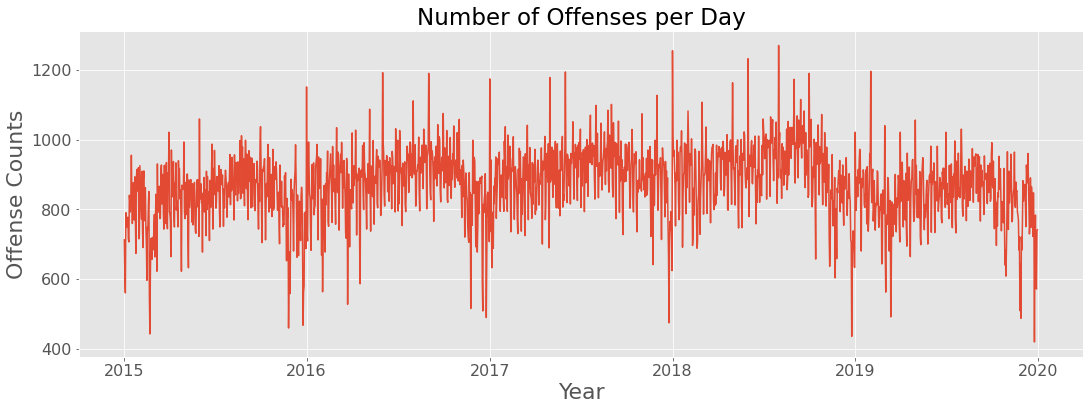

In [13]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(18,6))

    ax.plot(ts.index, ts.values)
    ax.set_title('Number of Offenses per Day', fontsize=23);
    ax.set_ylabel('Offense Counts', fontsize=22);
    ax.set_xlabel('Year', fontsize=22);
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    plt.show()

In [14]:
ts_weekly=ts.resample('W').mean()


In [15]:
with open('data/pickled_ts/ts_weekly.pickle', 'wb') as f:
    pickle.dump(ts_weekly, f)

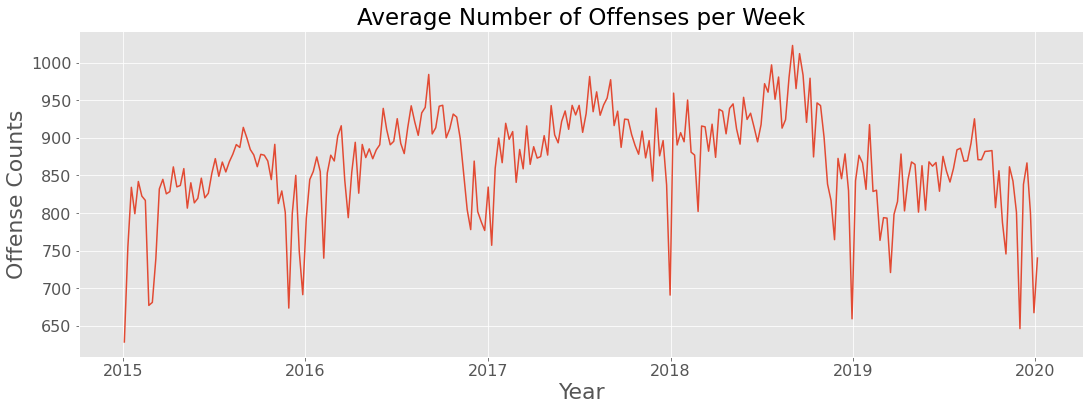

In [16]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(18,6))

    ax.plot(ts_weekly.index, ts_weekly.values)
    ax.set_title('Average Number of Offenses per Week', fontsize=23);
    ax.set_ylabel('Offense Counts', fontsize=22);
    ax.set_xlabel('Year', fontsize=22);
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    plt.show()


In [17]:
ts_ma=ts_weekly.rolling(52).mean()

In [18]:
ts_ewm=ts_weekly.ewm(span=52).mean()

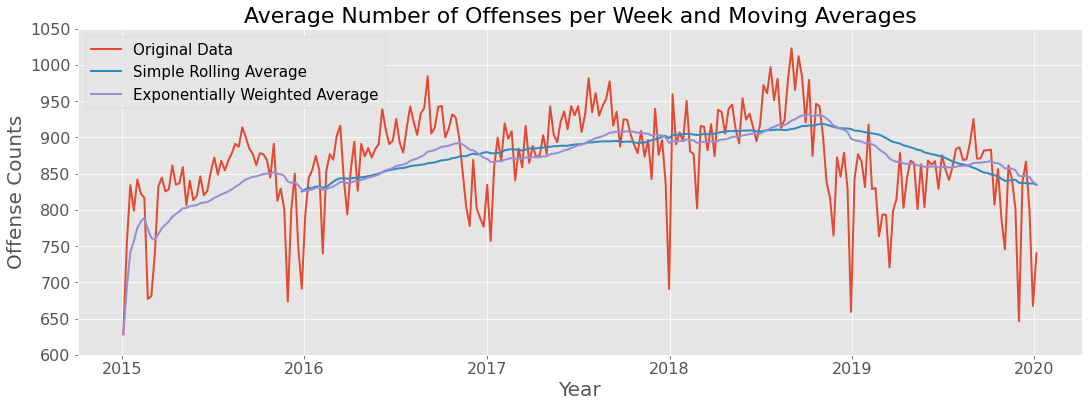

In [19]:
fig=display_figure_w_TSs(ts_weekly, ts_ma, 'Original Data', 'Simple Rolling Average',
                     'Average Number of Offenses per Week and Moving Averages', n=3,
                     ts3=ts_ewm, ts4=None, label3='Exponentially Weighted Average', label4=None)

<br><br><span style="font-size:1.2em;">EWA displays a clear upward trend with a seasonality while SRA does not pick up the seasonal fluctuation tendency. The seasonality is quite pronounced and is of an additive nature. The problematic range of dates is a period from the late 2018 till the end of 2019 when the trend changes to a downward trend. Unfortunately, cutting off a test set with the latest dates will make it impossible to predict the overall trend correctly.</span><br><br>
    
    

<Figure size 640x480 with 0 Axes>

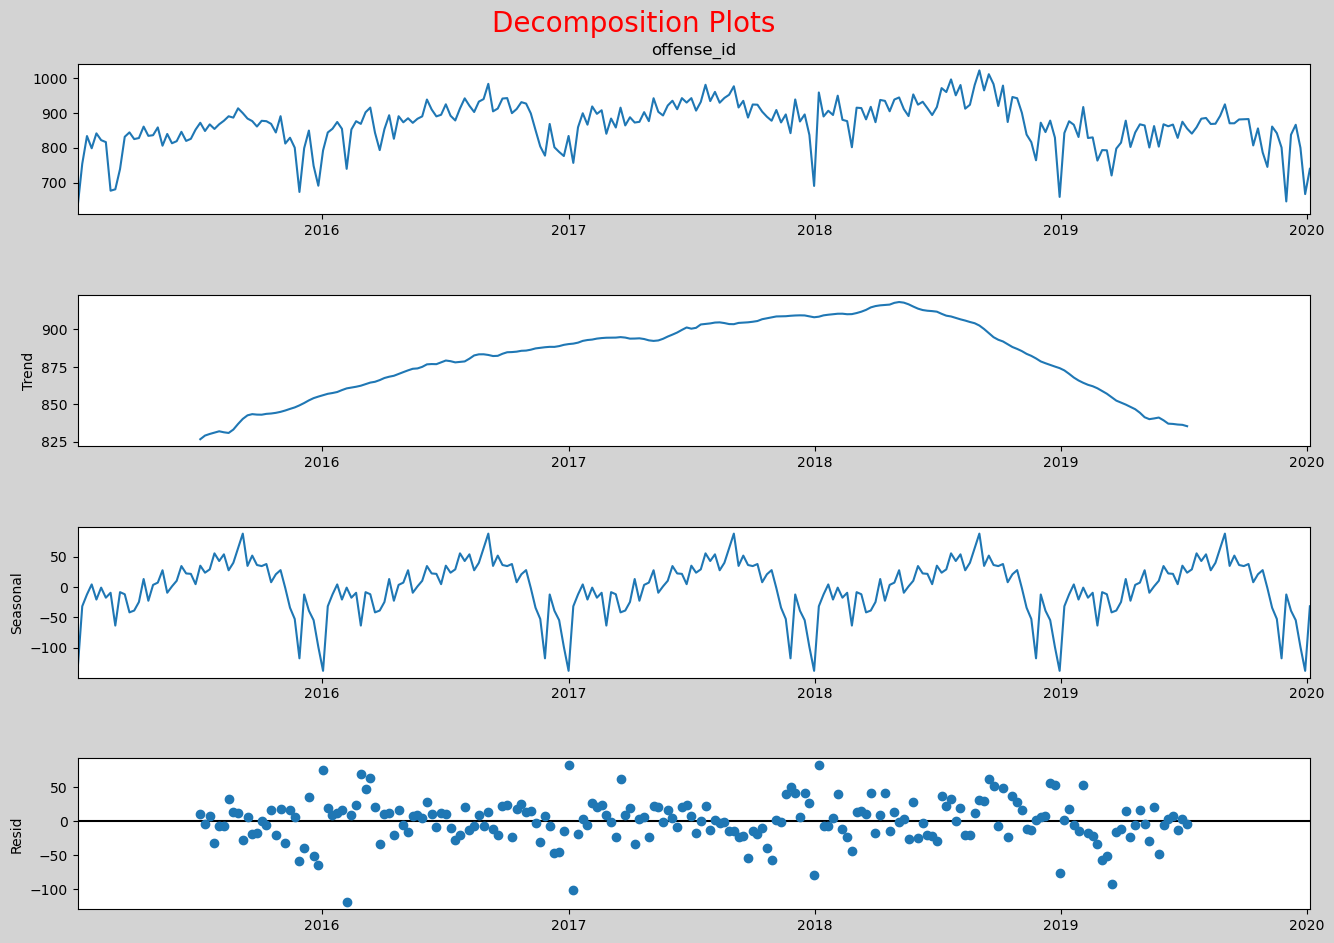

In [20]:
decomposing(ts_weekly);

In [21]:
# with open('images/pickled_figs/decomposition_plot_ts_weekly.pickle', 'wb') as f:
#     pickle.dump(decomposing(ts_weekly),f)

<br><br><span style="font-size:1.2em;"><b>The time series displays a clear trend along with seasonal fluctuations. Seasonality is comparable with the overall trend values (>10%)</b></span>.<br><br>


### Testing for Stationarity

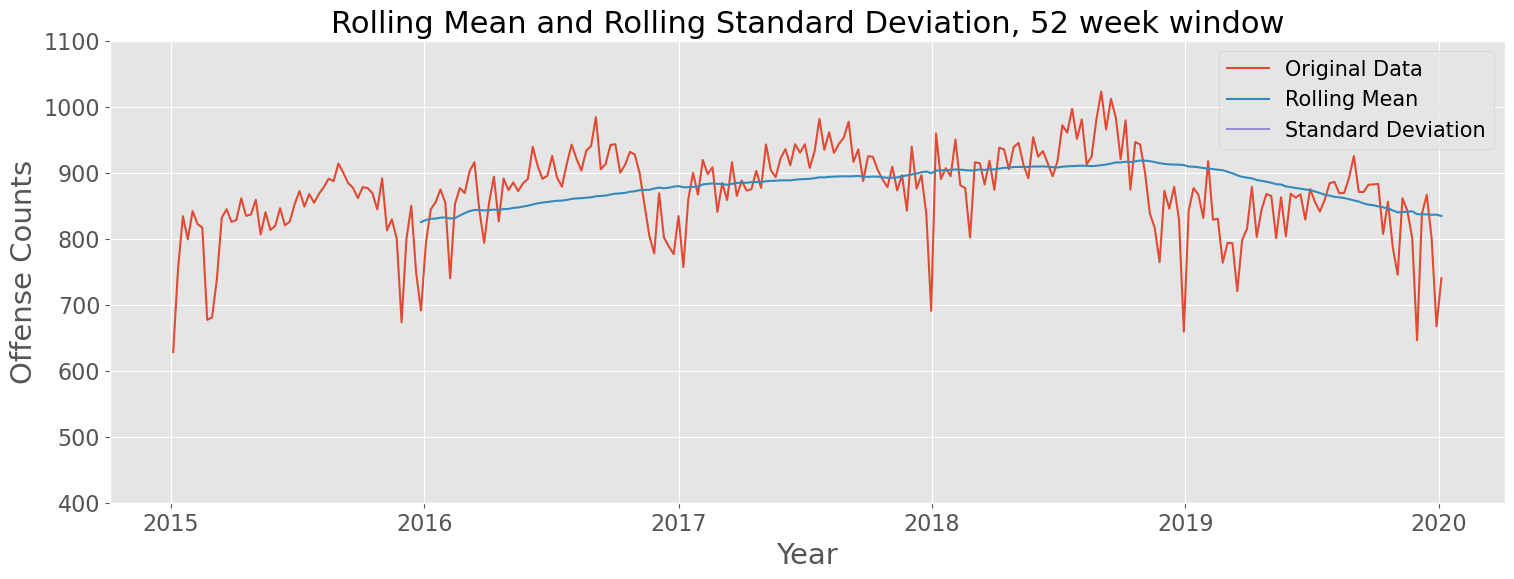

T_value   P_value  Lags  Observations  \
Dickey-Fuller test results -3.224157  0.018628     3           258   

                            Critical value, 1%  Critical value, 5%  \
Dickey-Fuller test results           -3.455953           -2.872809   

                            Critical value, 10%  Stationary?  
Dickey-Fuller test results            -2.572775         True

In [22]:
check_stationarity(ts_weekly, 'Original Data', min_=400, max_=1100)

<br><br><span style="font-size:1.2em;">The time-series is more or less **stationary**, p-value is 0.02 (<0.05). Visually it is not very stationary, the trend is somewhat visible. Since critical value -3.22 > -3.46, but < -2.87 (t-values at 1% and 5% confidence intervals), null hypothesis is rejected. However, the TS might benefit from stationarization </span><br><br>


 

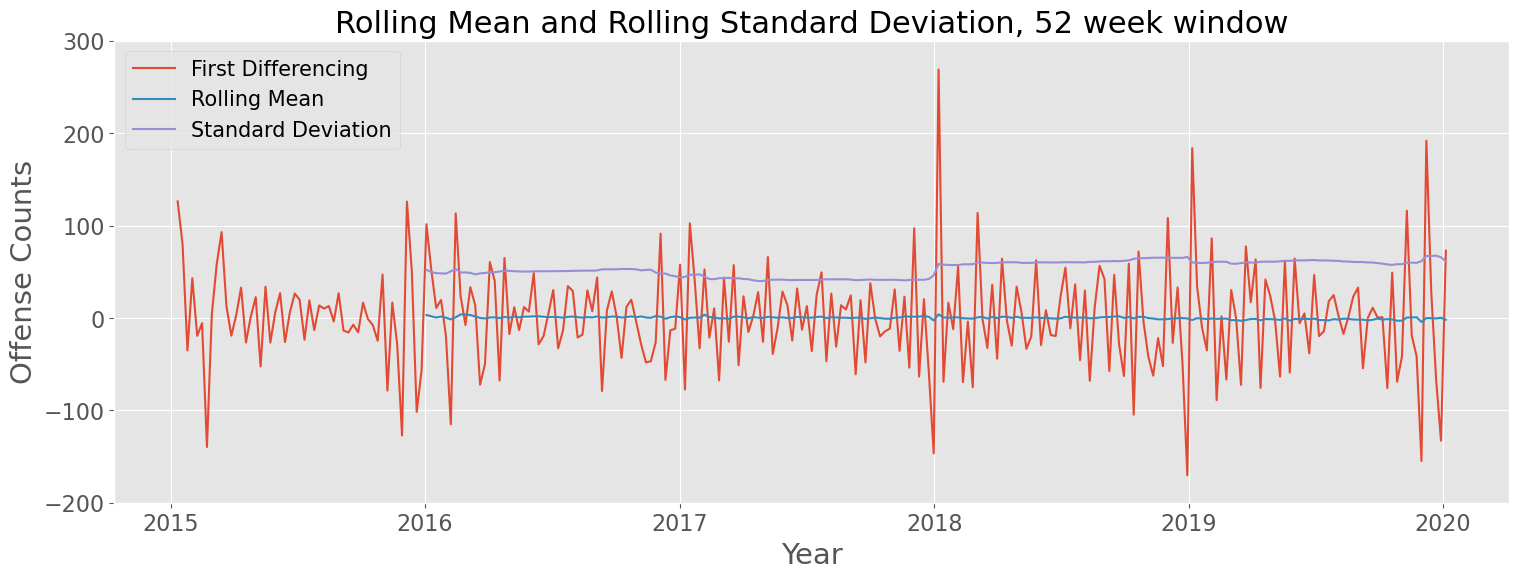

T_value   P_value  Lags  Observations  \
Dickey-Fuller test results -4.872453  0.000039    12           248   

                            Critical value, 1%  Critical value, 5%  \
Dickey-Fuller test results           -3.456996           -2.873266   

                            Critical value, 10%  Stationary?  
Dickey-Fuller test results            -2.573019         True

In [23]:
ts_diff1=ts_weekly.diff().dropna()

check_stationarity(ts_diff1, 'First Differencing', min_=-200, max_=300)

<br><br><span style="font-size:1.2em;">The first differenceing time-series is **stationary**, p-value is 3.9e-5 (well below 0.05). Also the critical value -4.87 < -3.46,-2.87  (t-values at 1% and 5% confidence intervals); null hypothesis is rejected.</span><br><br>

<Figure size 640x480 with 0 Axes>

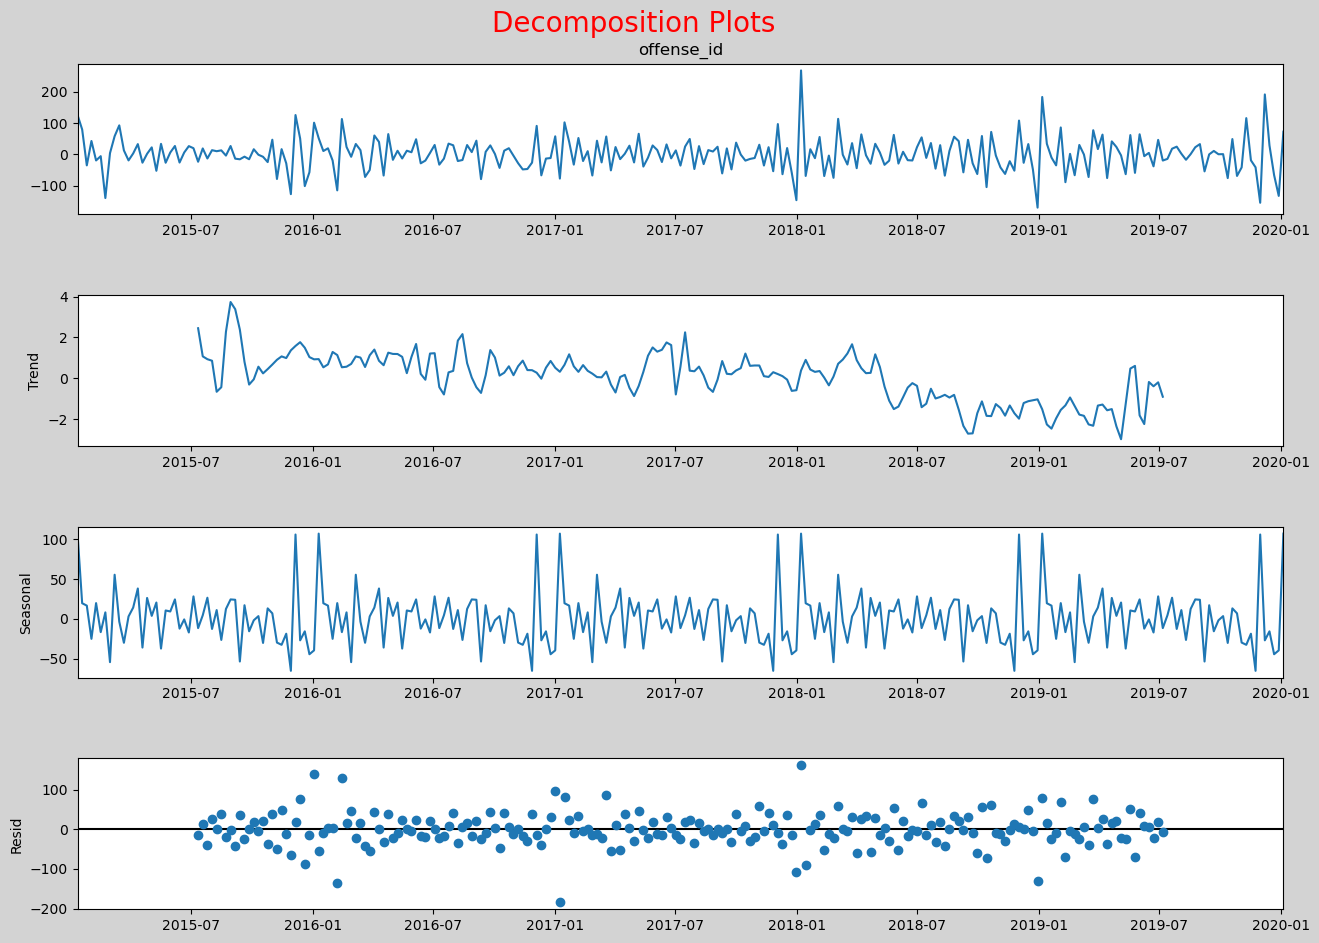

In [24]:
decomposing(ts_diff1);

<br><br><span style="font-size:1.2em;">The first differencing time-series decomposition displays clear seasonality.</span><br><br>

## General Crime Rate Modeling

### Splitting into a training and a test sets

<br><br><span style="font-size:1.2em;">I am cutting off a ~10% tail of my data to create a test set because I want the downswing of the data in the last year to be included in the training dataset</span><br>

In [25]:
train_size = round(len(ts_weekly) * 0.90)
ts_train, ts_test = ts_weekly[:train_size], ts_weekly[train_size:]
print('Observations: %d weeks' % (len(ts_weekly)))
print('Training Observations: %d weeks' % (len(ts_train)))
print('Testing Observations: %d weeks' % (len(ts_test)))

Observations: 262 weeks
Training Observations: 236 weeks
Testing Observations: 26 weeks


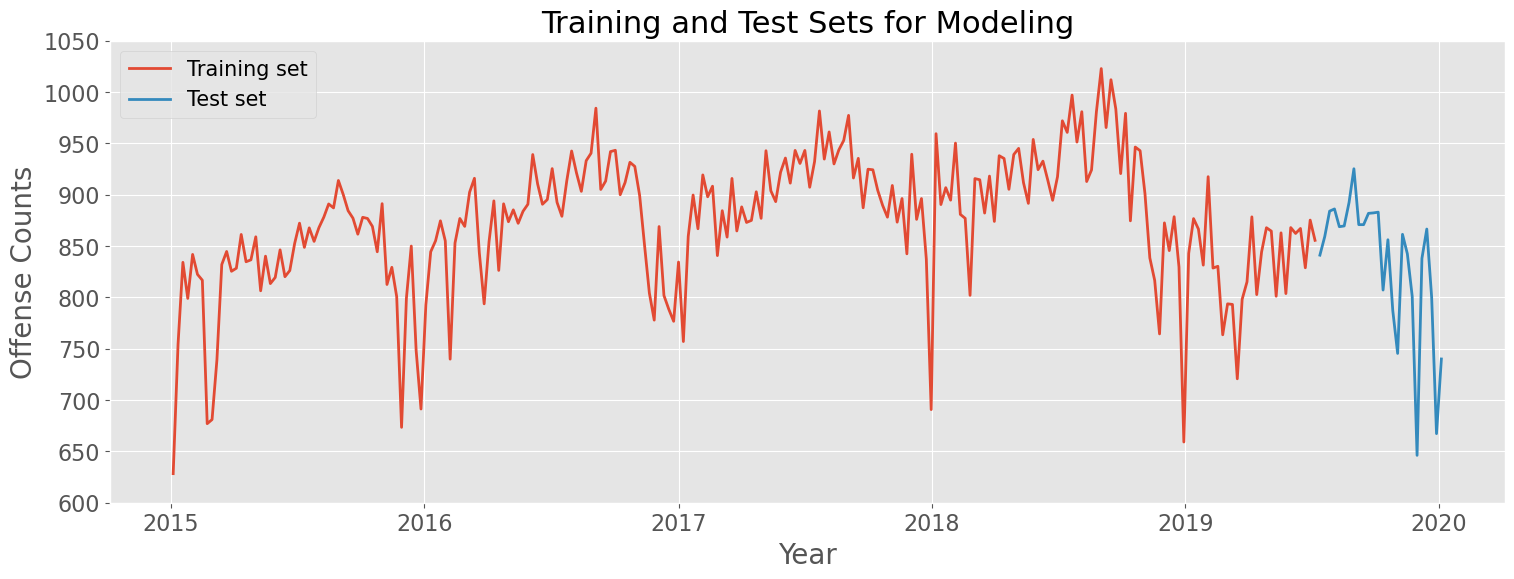

In [26]:
fig=display_figure_w_TSs(ts_train, ts_test, 'Training set', 'Test set', 'Training and Test Sets for Modeling')

In [27]:
with open('images/pickled_figs/ts_weekly_train_test.pickle', 'wb') as f:
    pickle.dump(fig,f)

### Partial Autocorrelation  and Autocorrelation Functions

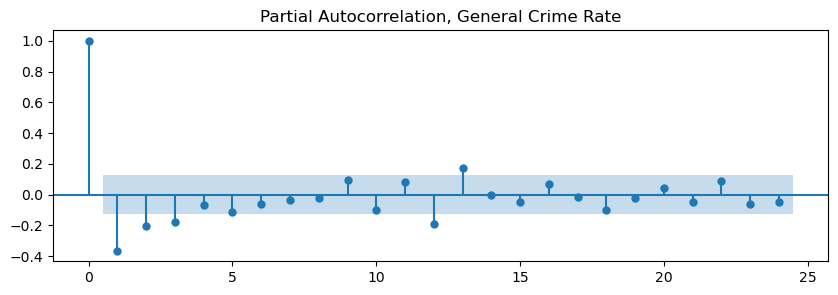

In [28]:
matplotlib.rc_file_defaults()
plt.rc("figure", figsize=(10,3))
plot_pacf(ts_train.diff().dropna(), title='Partial Autocorrelation, General Crime Rate');

<br><br><span style="font-size:1.2em;">Partial autocorrelation function of the first ts differencing indicates the importance of the first 3 lags.</span><br><br>

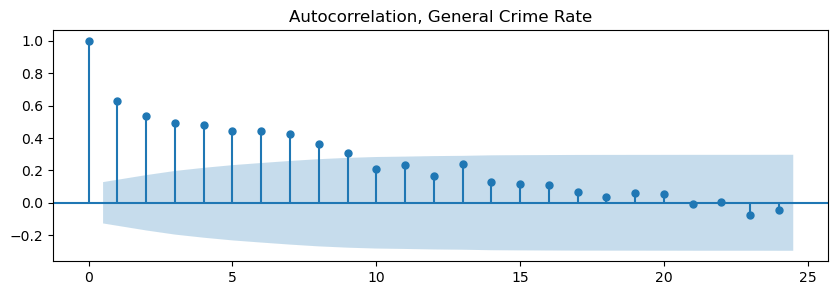

In [29]:
matplotlib.rc_file_defaults()
plt.rc("figure", figsize=(10,3))
plot_acf(ts_train, title='Autocorrelation, General Crime Rate');

<br><br><span style="font-size:1.2em;">The ACF shows a long persistent autocorrelation up to the 9th lag. That is a strong indicator that the differencing should be taken to stationarize the TS.</span><br><br>

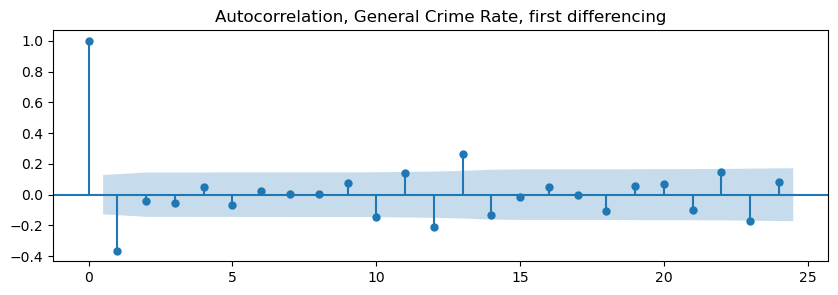

In [30]:
matplotlib.rc_file_defaults()
plt.rc("figure", figsize=(10,3))
plot_acf(ts_train.diff().dropna(), title='Autocorrelation, General Crime Rate, first differencing');

<br><br><span style="font-size:1.2em;">The ACF of the differenced series displays the  sharp cut-off and the negative lag1 correlation and therefore one MA term could be added to the model.</span><br><br>

### Baseline Model

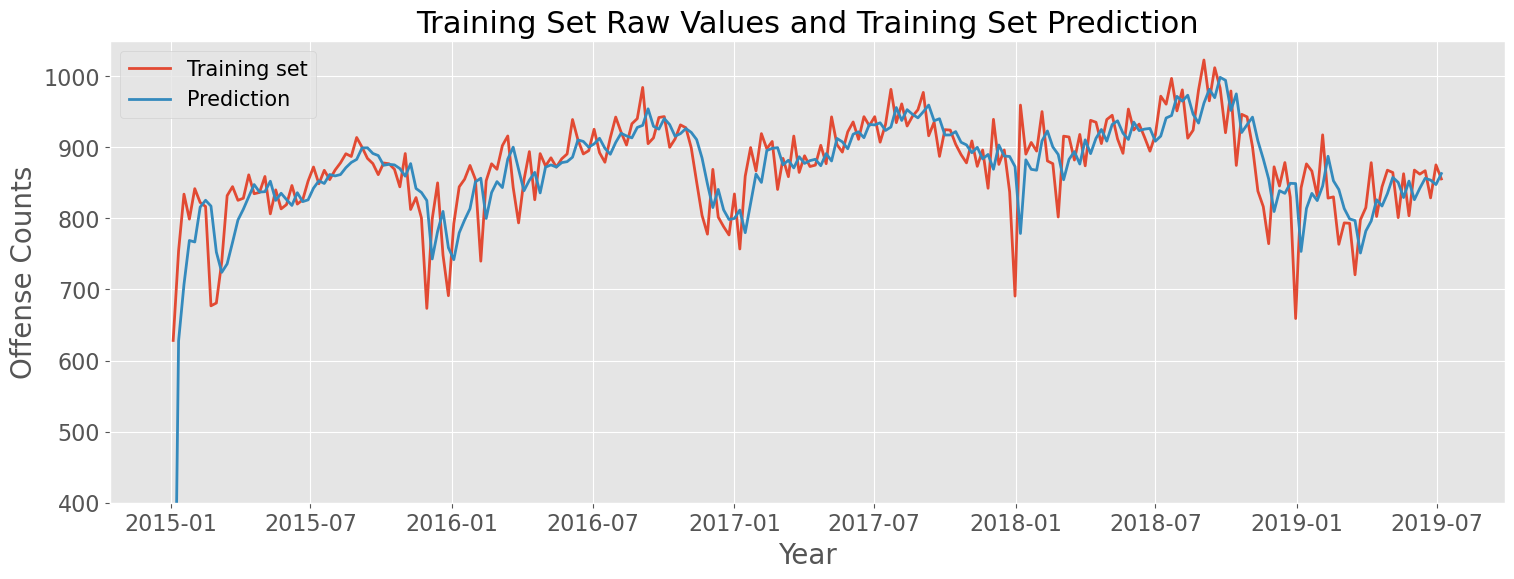

In [31]:
arima_1=ARIMA(ts_train, order=(3,1,0)).fit()
y_hat_train=arima_1.predict(typ='levels')


fig=display_figure_w_TSs(ts_train, y_hat_train, 'Training set', 'Prediction', 
                     'Training Set Raw Values and Training Set Prediction', min_=400)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             offense_id   No. Observations:                  236
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -1240.793
Date:                Wed, 28 Jul 2021   AIC                           2489.586
Time:                        19:46:25   BIC                           2503.424
Sample:                    01-04-2015   HQIC                          2495.165
                         - 07-07-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5013      0.046    -10.995      0.000      -0.591      -0.412
ar.L2         -0.3149      0.063     -4.999      0.000      -0.438      -0.191
ar.L3         -0.1955      0.059     -3.317      0.001      -0.311      -0.080
sigma2      2253.0732    148.340     15.189      0.000    1962.332    2543.815
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.53
Prob(H) (two-sided):                  0.95   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

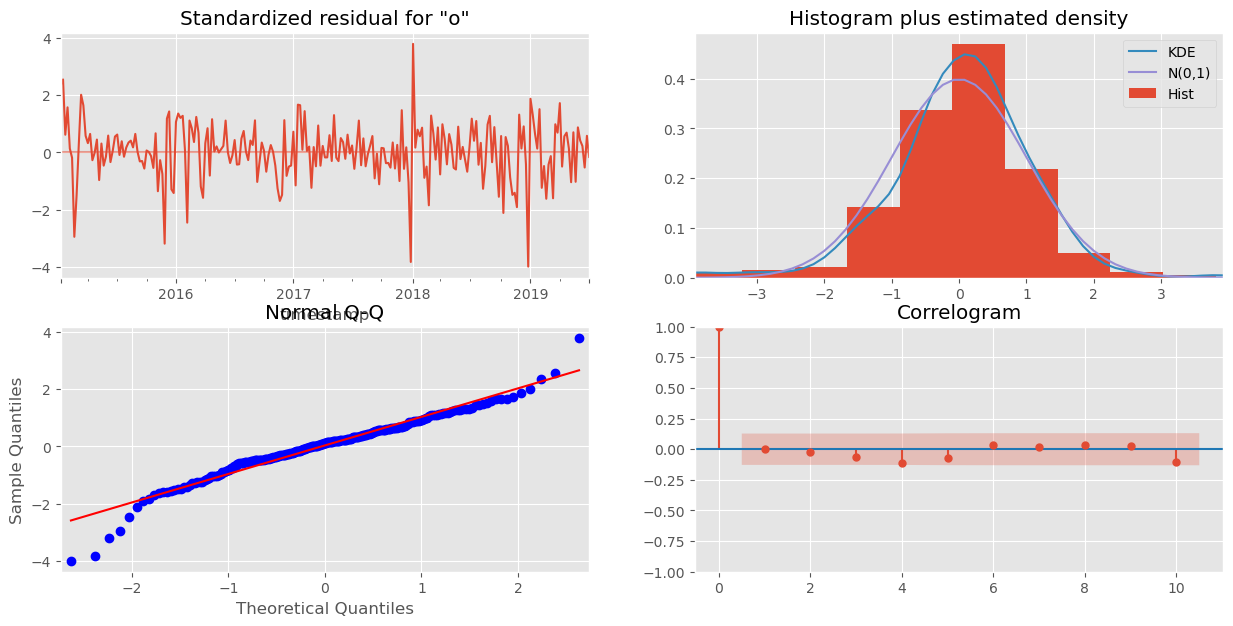

In [32]:
diagnostics(arima_1)

##### Testing the model

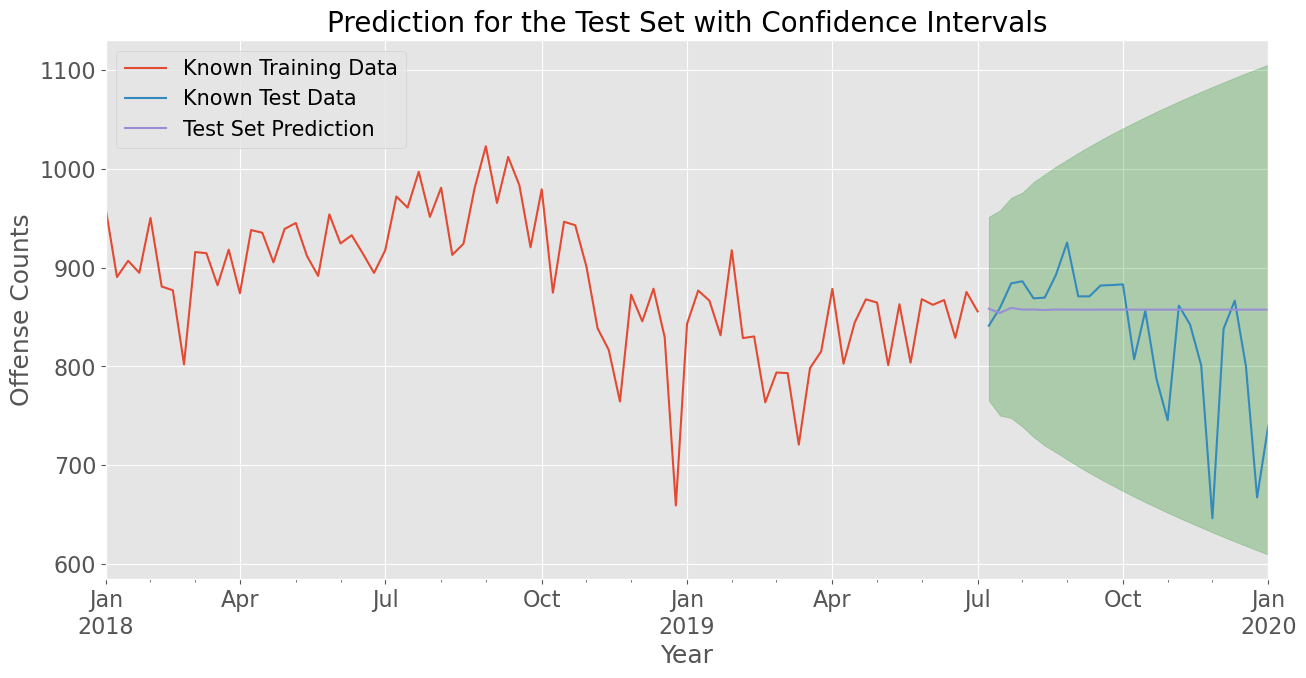

In [33]:
fig=predictions_testset(ts_train, ts_test, arima_1)

In [34]:
with open('images/pickled_figs/arima_train_test.pickle', 'wb') as f:
    pickle.dump(fig,f)

<br><br><span style="font-size:1.2em; background:lightblue">The ARIMA model above is our Baseline model</span><br><br>


### SARIMAX models

#### No exogenous regressors

<br><span style="font-size:1.2em;">It's a manual grid search section. I tried several combinations of pdq/PDQs and it seems that the most appropriate tryout ranges for MA terms and for AR terms in both trend and seasonal parts of the models are 0-1 and 0-3 respectively.</span><br><br>


In [35]:
p=range(0,4)
q=range(0,2)
pdq=list(itertools.product(p,[1],q))

P=range(0,4)
Q=range(0,2)
seasonal_pdq=[(x[0], x[1], x[2], 52) for x in list(itertools.product(P,[1],Q))]

for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX combination: {}x{}'.format(i,s))

SARIMAX combination: (0, 1, 0)x(0, 1, 0, 52)
SARIMAX combination: (0, 1, 0)x(0, 1, 1, 52)
SARIMAX combination: (0, 1, 0)x(1, 1, 0, 52)
SARIMAX combination: (0, 1, 0)x(1, 1, 1, 52)
SARIMAX combination: (0, 1, 0)x(2, 1, 0, 52)
SARIMAX combination: (0, 1, 0)x(2, 1, 1, 52)
SARIMAX combination: (0, 1, 0)x(3, 1, 0, 52)
SARIMAX combination: (0, 1, 0)x(3, 1, 1, 52)
SARIMAX combination: (0, 1, 1)x(0, 1, 0, 52)
SARIMAX combination: (0, 1, 1)x(0, 1, 1, 52)
SARIMAX combination: (0, 1, 1)x(1, 1, 0, 52)
SARIMAX combination: (0, 1, 1)x(1, 1, 1, 52)
SARIMAX combination: (0, 1, 1)x(2, 1, 0, 52)
SARIMAX combination: (0, 1, 1)x(2, 1, 1, 52)
SARIMAX combination: (0, 1, 1)x(3, 1, 0, 52)
SARIMAX combination: (0, 1, 1)x(3, 1, 1, 52)
SARIMAX combination: (1, 1, 0)x(0, 1, 0, 52)
SARIMAX combination: (1, 1, 0)x(0, 1, 1, 52)
SARIMAX combination: (1, 1, 0)x(1, 1, 0, 52)
SARIMAX combination: (1, 1, 0)x(1, 1, 1, 52)
SARIMAX combination: (1, 1, 0)x(2, 1, 0, 52)
SARIMAX combination: (1, 1, 0)x(2, 1, 1, 52)
SARIMAX co

In [36]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             sarimax_mod=SARIMAX(ts_train,
#                                 order=param,
#                                 seasonal_order=param_seasonal,
#                                 enforce_invertibility=False)
#             results=sarimax_mod.fit()
#             print('ARIMA{}x{}-AIC:{}:'.format(param, param_seasonal,results.aic))
#         except:
#             print('Error!')
#             continue

##### <br><br><span style="font-size:1.2em;">**ARIMA(3, 1, 0)x(3, 1, 0, 52)-AIC:256.74:** is our best model. it took 55 minutes to complete this search. Therefore I am commenting out this snippet.</span><br><br>



In [37]:
# sarimax_mod1=SARIMAX(ts_train,
#                     order=(3, 1, 0),
#                     seasonal_order=(3, 1, 0, 52),
#                     enforce_invertibility=False).fit()


<br><br><span style="font-size:1.2em;">The model above took 44 seconds to fit but just in case it is pickled to be used forward.</span><br><br>



In [38]:
# with open('data/pickled_models/sarimax_mod1.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod1, f)

In [39]:
with open('data/pickled_models/sarimax_mod1.pickle', 'rb') as f:
    sarimax_mod1=pickle.load(f)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         offense_id   No. Observations:                  236
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 52)   Log Likelihood                -971.969
Date:                            Wed, 28 Jul 2021   AIC                           1957.937
Time:                                    19:46:27   BIC                           1980.403
Sample:                                01-04-2015   HQIC                          1967.044
                                     - 07-07-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6356      0.056    -11.337      0.000      -0.745      -0.526
ar.L2         -0.3886      0.066     -5.877      0.000      -0.518      -0.259
ar.L3         -0.1715      0.075     -2.292      0.022      -0.318      -0.025
ar.S.L52      -0.6286      0.092     -6.800      0.000      -0.810      -0.447
ar.S.L104     -0.4472      0.151     -2.960      0.003      -0.743      -0.151
ar.S.L156     -0.2381      0.165     -1.439      0.150      -0.562       0.086
sigma2      2033.5387    269.943      7.533      0.000    1504.460    2562.617
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                39.08
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.24
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

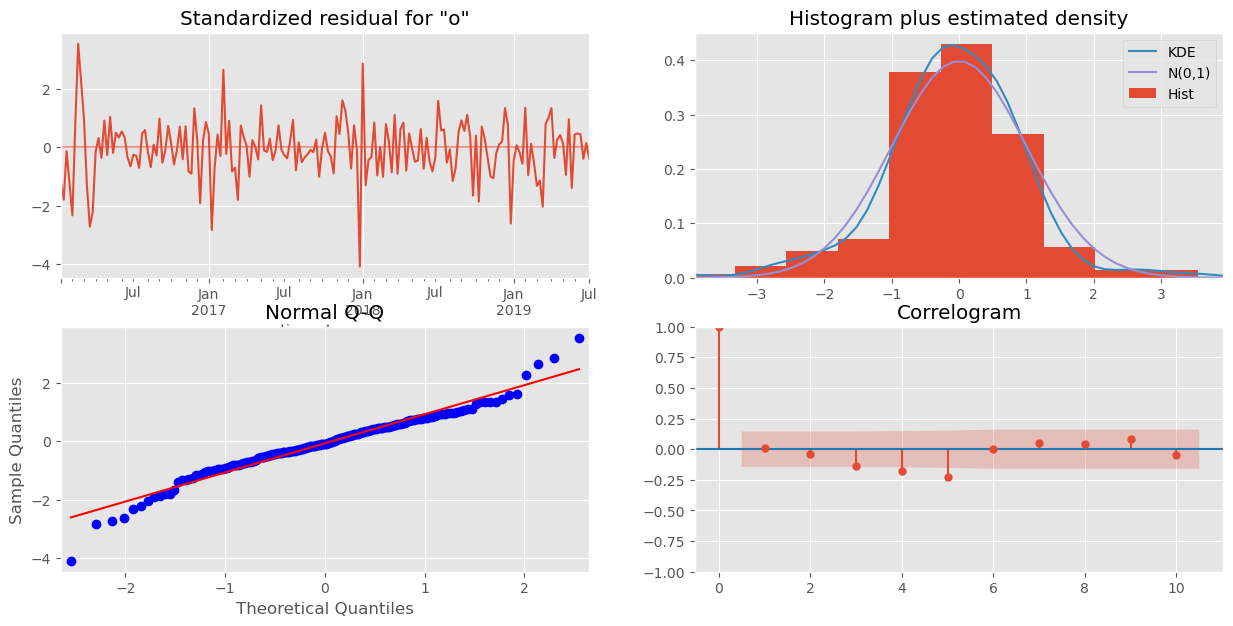

In [40]:
diagnostics(sarimax_mod1)

##### Testing

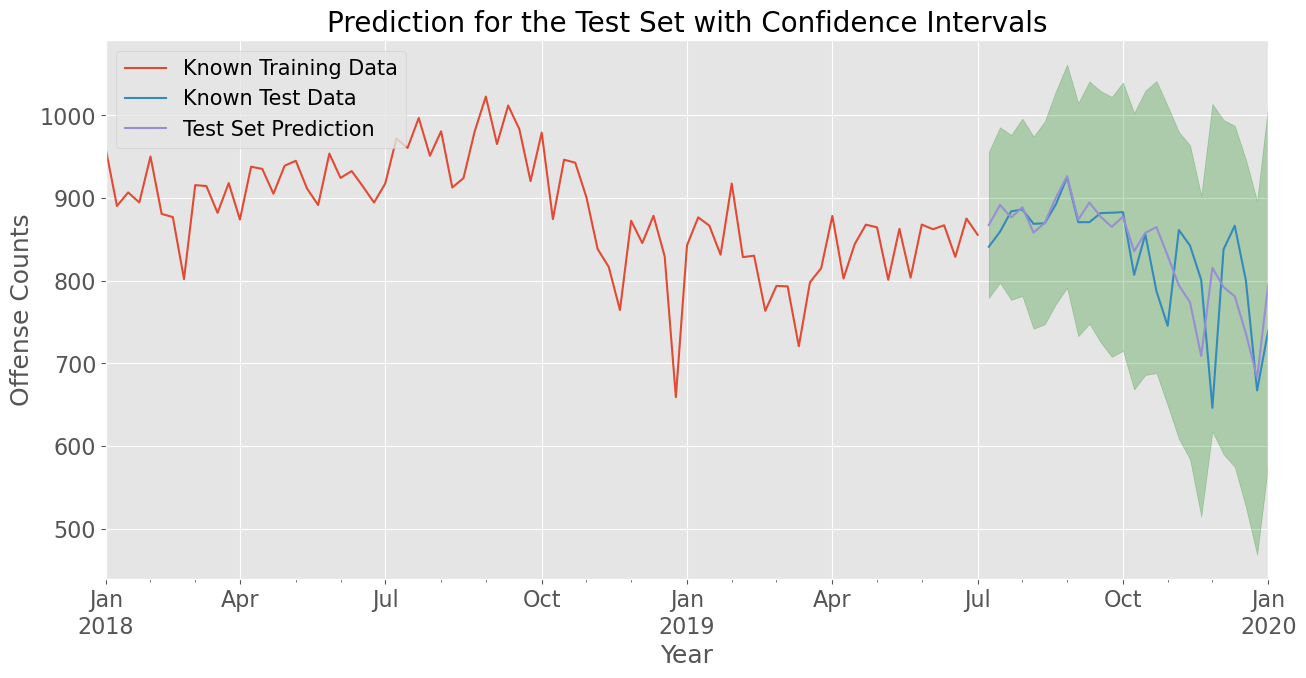

In [41]:
fig=predictions_testset(ts_train, ts_test, sarimax_mod1)

In [42]:
with open('images/pickled_figs/sarimax_mod1_train_test.pickle', 'wb') as f:
    pickle.dump(fig,f)

<br><br><span style="font-size:1.2em;">The RMSE value is significantly better than the RMSE for the Baseline model. Though visually the prediction for the train and test sets are not perfect.</span><br><br>

#### Adding US holidays as exogenous regressors

<br><span style="font-size:1.2em;">I will add holiday exogenous variables as an additional argument to the SARIMAX model to see if it helps improving the performance.</span><br><br>

In [43]:
ts_holidays_weekly=us_holidays_predictors_TS(start='1/1/2015',
    end='12/31/2019',
    years=range(2015, 2020),
    freq='W')

In [44]:
# Spliting exogenous TS into the training and the test parts

train_size_holidays = round(len(ts_holidays_weekly) * 0.90)
ts_train_holiday, ts_test_holiday = ts_holidays_weekly[:train_size], ts_holidays_weekly[train_size:]

In [45]:
# sarimax_mod2=SARIMAX(ts_train, exog=ts_train_holiday,
#                     order=(3, 1, 0),
#                     seasonal_order=(3, 1, 0, 52),
#                     enforce_invertibility=False).fit()


<br><br><span style="font-size:1.2em;">The model above took 1.5 minute to fit, therefore it is pickled to be used forward.</span><br><br>

In [46]:
# with open('data/pickled_models/sarimax_mod2.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod2, f)

In [47]:
with open('data/pickled_models/sarimax_mod2.pickle', 'rb') as f:
    sarimax_mod2=pickle.load(f)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         offense_id   No. Observations:                  236
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 52)   Log Likelihood                -971.795
Date:                            Wed, 28 Jul 2021   AIC                           1959.590
Time:                                    19:46:29   BIC                           1985.266
Sample:                                01-04-2015   HQIC                          1969.998
                                     - 07-07-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday       -5.5068     12.288     -0.448      0.654     -29.591      18.577
ar.L1         -0.6332      0.058    -10.933      0.000      -0.747      -0.520
ar.L2         -0.3928      0.067     -5.833      0.000      -0.525      -0.261
ar.L3         -0.1735      0.076     -2.276      0.023      -0.323      -0.024
ar.S.L52      -0.6326      0.092     -6.841      0.000      -0.814      -0.451
ar.S.L104     -0.4542      0.150     -3.020      0.003      -0.749      -0.159
ar.S.L156     -0.2450      0.163     -1.501      0.133      -0.565       0.075
sigma2      2021.2538    270.058      7.485      0.000    1491.949    2550.558
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                40.31
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.23
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

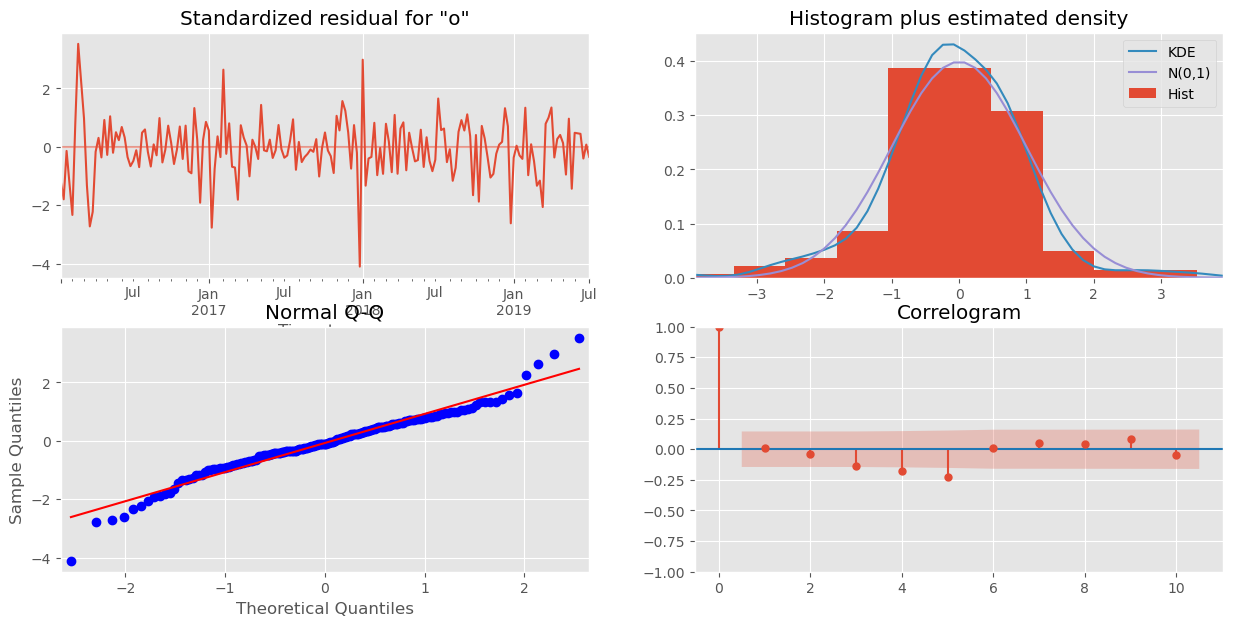

In [48]:
diagnostics(sarimax_mod2)

<span style="font-size:1.2em;">This model performed very slightly worse than the one without exogenous regressors in terms of AIC value.</span><br><br>

##### Testing

In [49]:
# plt.style.use('ggplot')
# y_hat_train=sarimax_mod2.predict(typ='levels')
# y_hat_test=sarimax_mod2.predict(start=ts_test.index[0], end=ts_test.index[-1], exog=ts_test_holiday,typ='levels')

# rmse = np.sqrt(mean_squared_error(ts_test, y_hat_test))
# print('RMSE of the SARIMAX model (w US holidays) is {}'.format(round(rmse,2)))


# fig=display_figure_w_TSs(ts_train, ts_test, 'Train set', 'Test set', 
#                      'Training and Test Sets Raw Values and Predictions (SARIMAX w US Holidays)',
#                       n=4, ts3=y_hat_test,
#                       ts4=y_hat_train, label3='Prediction for Test set', label4='Prediction for Training set')

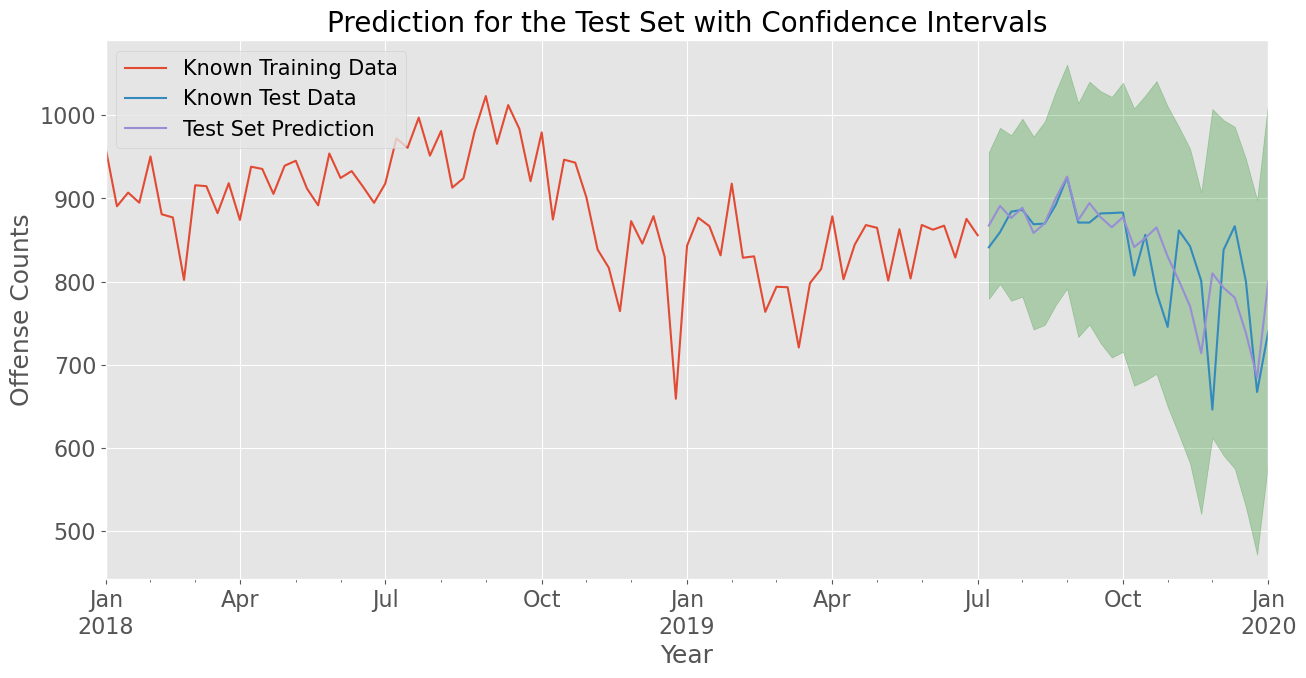

In [50]:
fig=predictions_testset(ts_train, ts_test, sarimax_mod2, egog_flag=True, exog=ts_test_holiday)

<span style="font-size:1.2em;">The RMSE value of this model is better than the one from the model w/o US holidays regressors.</span><br><br>

### Forecasting

#### SARIMAX w/o US holidays

###### ACF and PACF

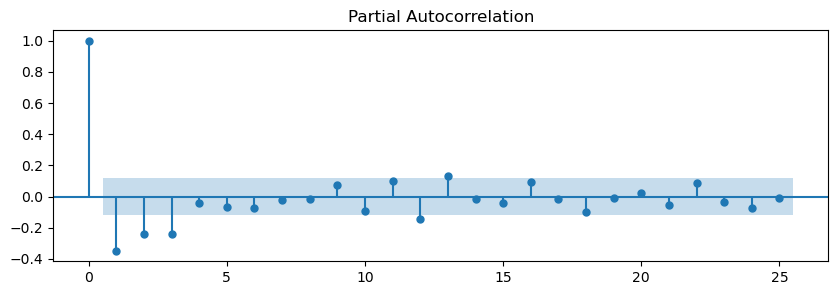

In [51]:
matplotlib.rc_file_defaults()
plt.rc("figure", figsize=(10,3))
plot_pacf(ts_weekly.diff().dropna());

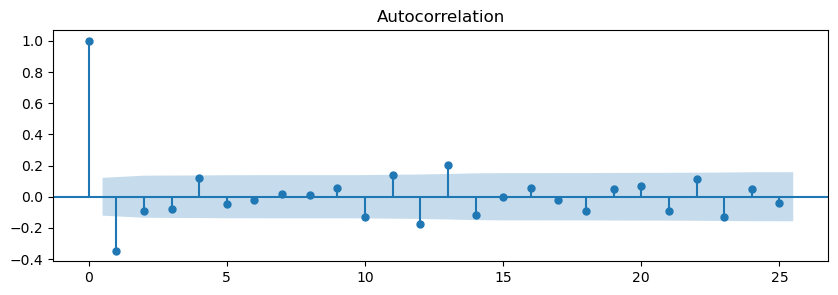

In [52]:
matplotlib.rc_file_defaults()
plt.rc("figure", figsize=(10,3))
plot_acf(ts_weekly.diff().dropna());

<br><br><span style="font-size:1.2em;">Based on PACF and ACF plots the same model would work best for the full dataset as well (not just the training subset).</span><br><br>



###### Fitting the model to the full dataset

In [53]:
# sarimax_mod1_for=SARIMAX(ts_weekly,
#                     order=(3, 1, 0),
#                     seasonal_order=(3, 1, 0, 52),
#                     enforce_invertibility=False).fit()

<br><br><span style="font-size:1.2em;">The model above took 43 seconds to fit, therefore it is pickled to be used forward.</span><br><br>



In [54]:
# with open('data/pickled_models/sarimax_mod1_for.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod1_for, f)

In [55]:
with open('data/pickled_models/sarimax_mod1_for.pickle', 'rb') as f:
    sarimax_mod1_for=pickle.load(f)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         offense_id   No. Observations:                  262
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 52)   Log Likelihood               -1119.803
Date:                            Wed, 28 Jul 2021   AIC                           2253.605
Time:                                    19:46:31   BIC                           2277.002
Sample:                                01-04-2015   HQIC                          2263.065
                                     - 01-05-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6327      0.050    -12.567      0.000      -0.731      -0.534
ar.L2         -0.4433      0.061     -7.311      0.000      -0.562      -0.324
ar.L3         -0.2734      0.058     -4.704      0.000      -0.387      -0.160
ar.S.L52      -0.5999      0.088     -6.819      0.000      -0.772      -0.427
ar.S.L104     -0.4110      0.124     -3.310      0.001      -0.654      -0.168
ar.S.L156     -0.1834      0.140     -1.312      0.189      -0.457       0.091
sigma2      2326.7001    217.935     10.676      0.000    1899.555    2753.846
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                65.24
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.42
Prob(H) (two-sided):                  0.97   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

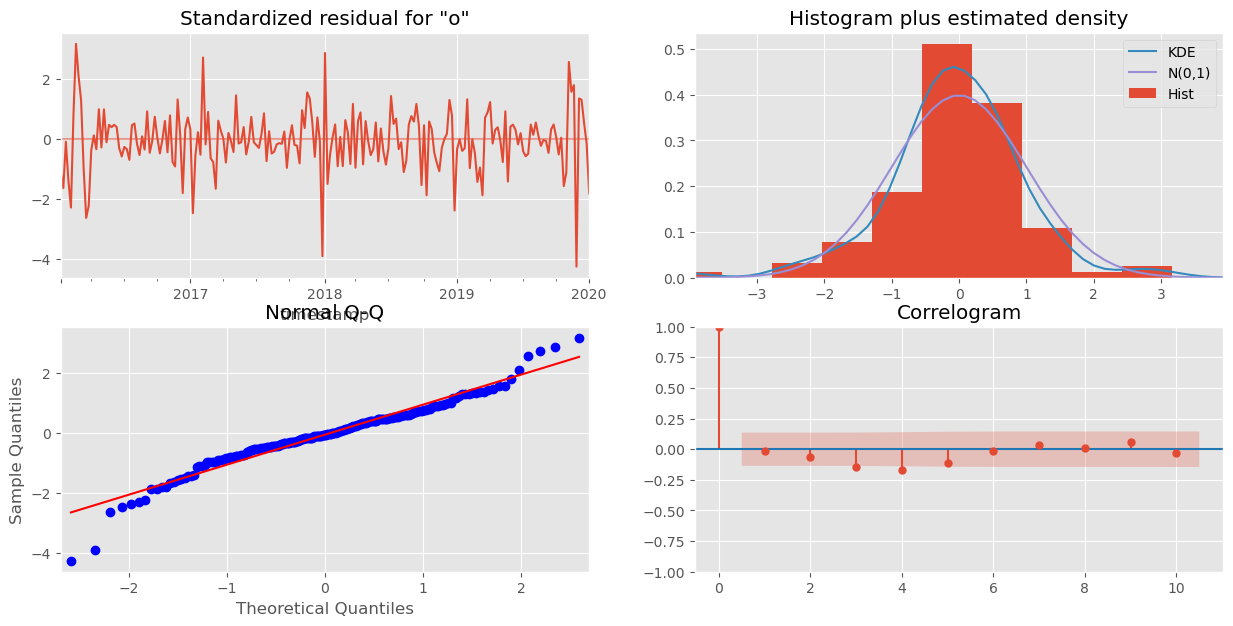

In [56]:
diagnostics(sarimax_mod1_for)

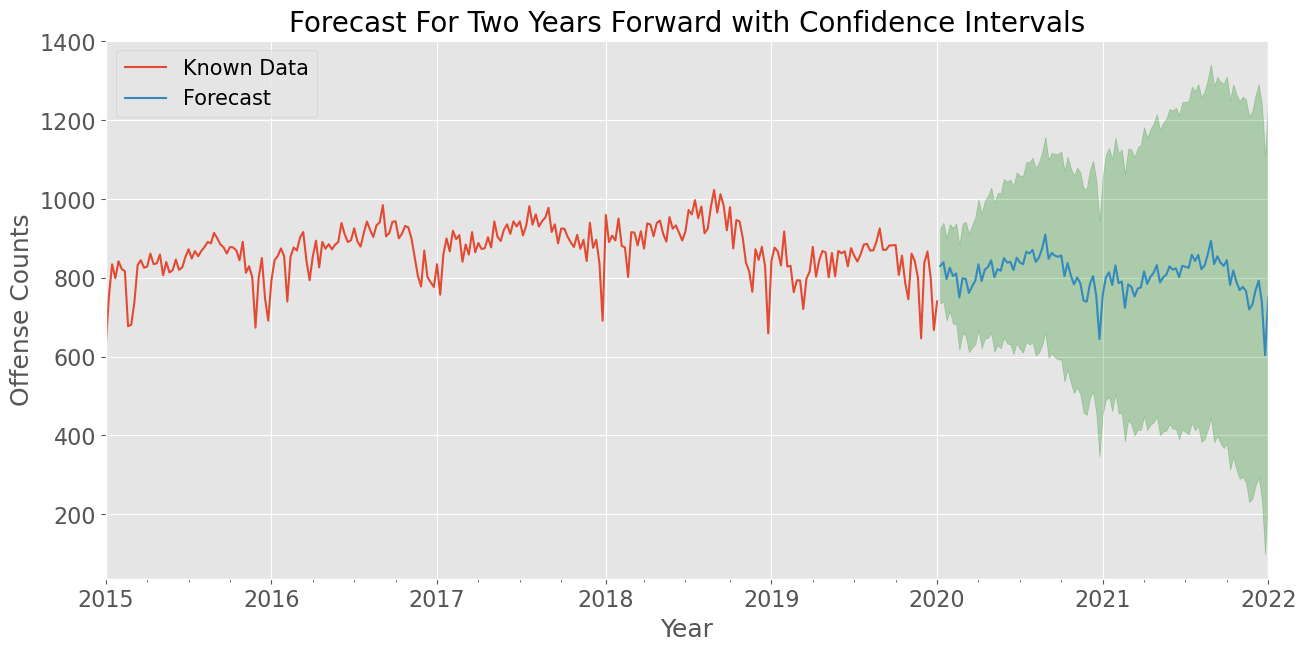

In [57]:

fig=plot_predictions(ts_weekly, sarimax_mod1_for, 'Forecast For Two Years Forward with Confidence Intervals',
                 steps=104, xmin='2015')


In [58]:
with open('images/pickled_figs/sarimax_mod1_forecast.pickle', 'wb') as f:
    pickle.dump(fig,f)

#### SARIMAX with US holidays

###### Fitting the model to the full dataset with full US holiday schedule

In [59]:
# sarimax_mod2_for=SARIMAX(ts_weekly, exog=ts_holidays_weekly,
#                     order=(3, 1, 0),
#                     seasonal_order=(3, 1, 0, 52),
#                     enforce_invertibility=False).fit()

<br><br><span style="font-size:1.2em;">The fitting of the model took 2.5 minutes therefore I am saving it to a pickle file.</span><br><br>



In [60]:
# with open('data/pickled_models/sarimax_mod2_for.pickle', 'wb') as f:
#     pickle.dump(sarimax_mod2_for, f)

In [61]:
with open('data/pickled_models/sarimax_mod2_for.pickle', 'rb') as f:
    sarimax_mod2_for=pickle.load(f)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         offense_id   No. Observations:                  262
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 52)   Log Likelihood               -1117.886
Date:                            Wed, 28 Jul 2021   AIC                           2251.771
Time:                                    19:46:33   BIC                           2278.510
Sample:                                01-04-2015   HQIC                          2262.582
                                     - 01-05-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday      -16.8103      6.897     -2.437      0.015     -30.328      -3.292
ar.L1         -0.6228      0.049    -12.602      0.000      -0.720      -0.526
ar.L2         -0.4621      0.061     -7.581      0.000      -0.582      -0.343
ar.L3         -0.2657      0.067     -3.936      0.000      -0.398      -0.133
ar.S.L52      -0.6029      0.091     -6.594      0.000      -0.782      -0.424
ar.S.L104     -0.4262      0.126     -3.372      0.001      -0.674      -0.178
ar.S.L156     -0.1967      0.144     -1.368      0.171      -0.478       0.085
sigma2      2271.3878    236.961      9.585      0.000    1806.952    2735.823
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                45.46
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.33
Prob(H) (two-sided):                  0.84   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

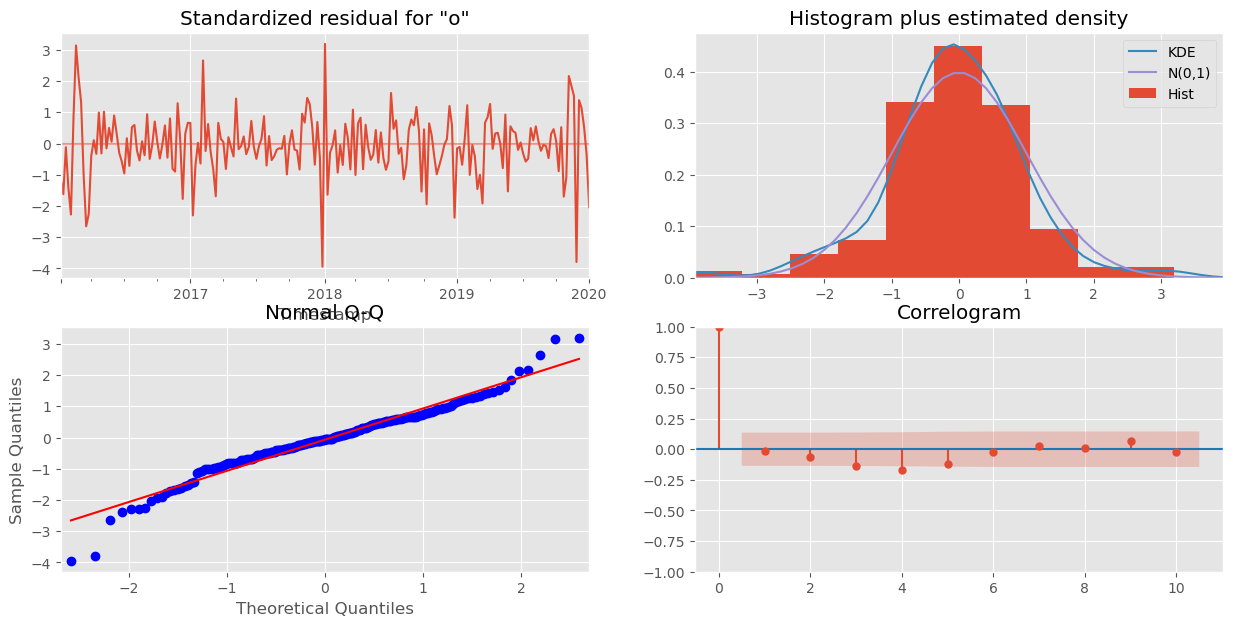

In [62]:
diagnostics(sarimax_mod2_for)

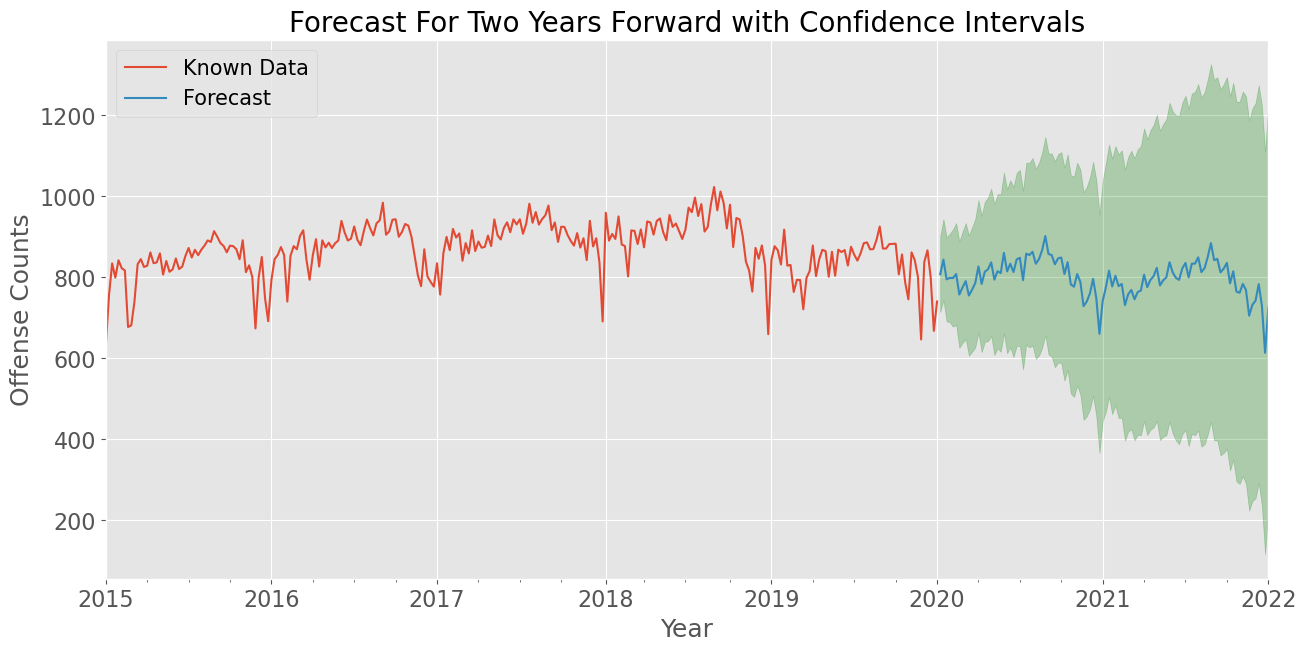

In [63]:
# I am extending the period to 105 weeks to cover all the span of the US_holidays TS above
# (it includes 53 weeks+52 weeks next year)

fig=plot_predictions(ts_weekly, sarimax_mod2_for, 'Forecast For Two Years Forward with Confidence Intervals',
                 steps=105, xmin='2015', 
                 egog_flag=True, exog=exog_reg_timeframe('1/1/2020', '1/1/2022'))


#### Auto ARIMA search for the best parameters

###### Training and testing

In [64]:
# auto_model_train = pmd.auto_arima(ts_train,
#                             start_p=0,start_q=0, d=1,
#                             max_p=3,max_q=1,
#                             max_P=3,max_Q=1,
#                             start_P=0, start_Q=0, D=1,
#                             m=52,trace=True,
#                             verbose=2)


![image of auto ARIMA search](images/auto_arima_search_results_general_crime.png)

<br><br><span style="font-size:1.2em;">The search above took 29.5 minutes to run, therefore it is pickled to be used forward.</span><br><br>



In [65]:
# with open('data/pickled_models/auto_model_train.pickle', 'wb') as f:
#     pickle.dump(auto_model_train, f)

In [66]:
with open('data/pickled_models/auto_model_train.pickle', 'rb') as f:
    auto_model_train=pickle.load(f)

In [67]:
model_auto_train = tsa.SARIMAX(ts_train, order=auto_model_train.order, 
                seasonal_order=auto_model_train.seasonal_order,
                enforce_invertibility=False, freq='W').fit()


In [68]:
with open('data/pickled_models/model_auto_train.pickle', 'wb') as f:
    pickle.dump(model_auto_train, f)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          offense_id   No. Observations:                  236
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 52)   Log Likelihood                -963.341
Date:                             Wed, 28 Jul 2021   AIC                           1936.683
Time:                                     19:46:52   BIC                           1952.730
Sample:                                 01-04-2015   HQIC                          1943.188
                                      - 07-07-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1223      0.065      1.885      0.059      -0.005       0.249
ma.L1         -0.8601      0.041    -20.853      0.000      -0.941      -0.779
ar.S.L52      -0.4910      0.061     -8.081      0.000      -0.610      -0.372
ar.S.L104     -0.2871      0.093     -3.091      0.002      -0.469      -0.105
sigma2      1979.7726    194.117     10.199      0.000    1599.309    2360.236
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.00
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.10
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

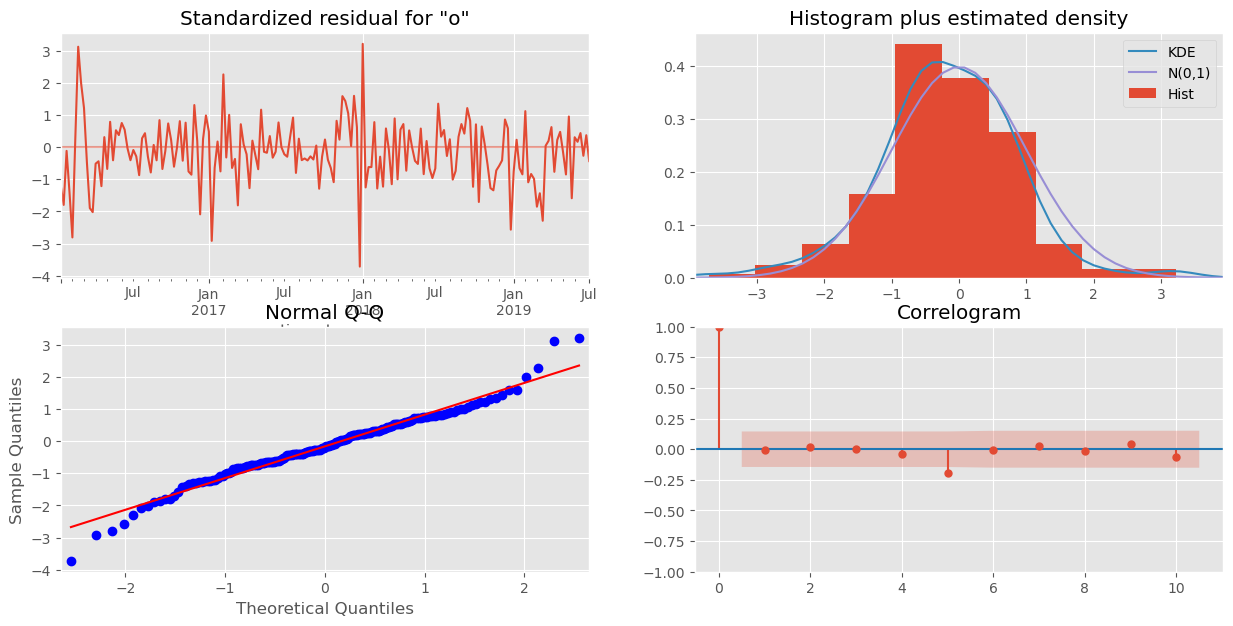

In [69]:
diagnostics(model_auto_train)

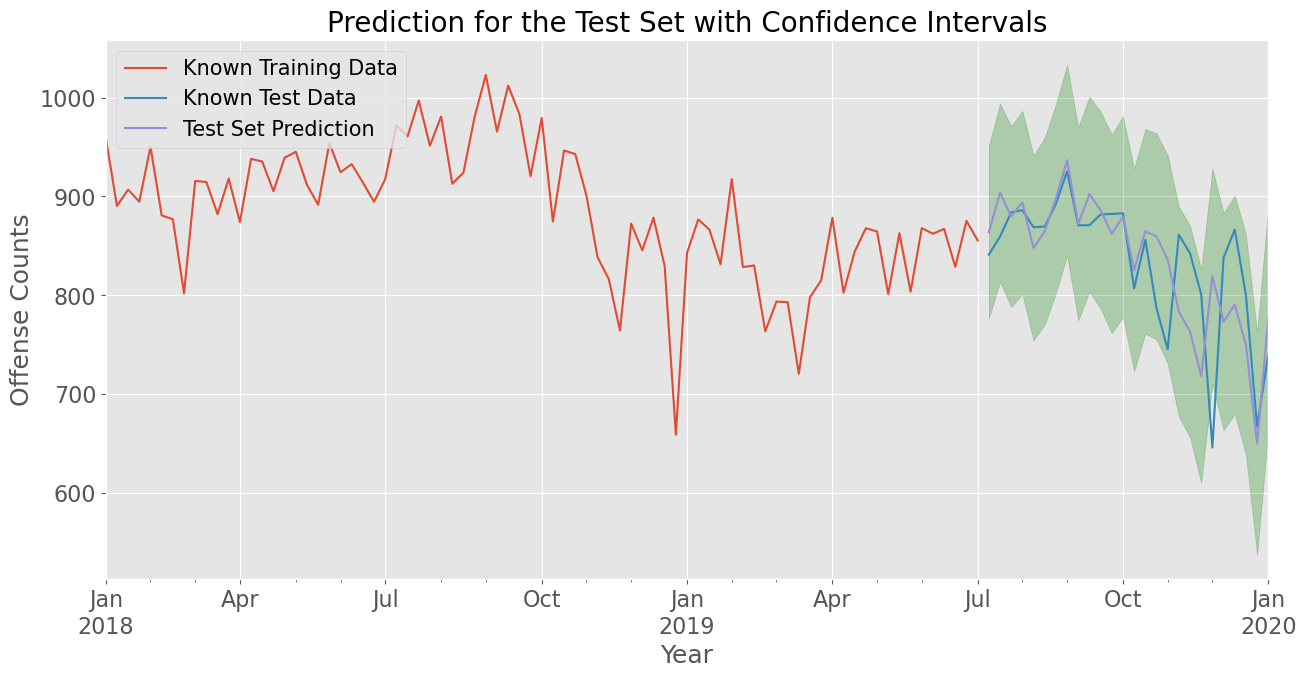

In [74]:
fig=predictions_testset(ts_train, ts_test, model_auto_train, xmin='2018')

In [71]:
model_auto_for = tsa.SARIMAX(ts_weekly, order=auto_model_train.order, 
                seasonal_order=auto_model_train.seasonal_order,
                enforce_invertibility=False, freq='W').fit()

In [72]:
with open('data/pickled_models/model_auto_for.pickle', 'wb') as f:
    pickle.dump(model_auto_for, f)

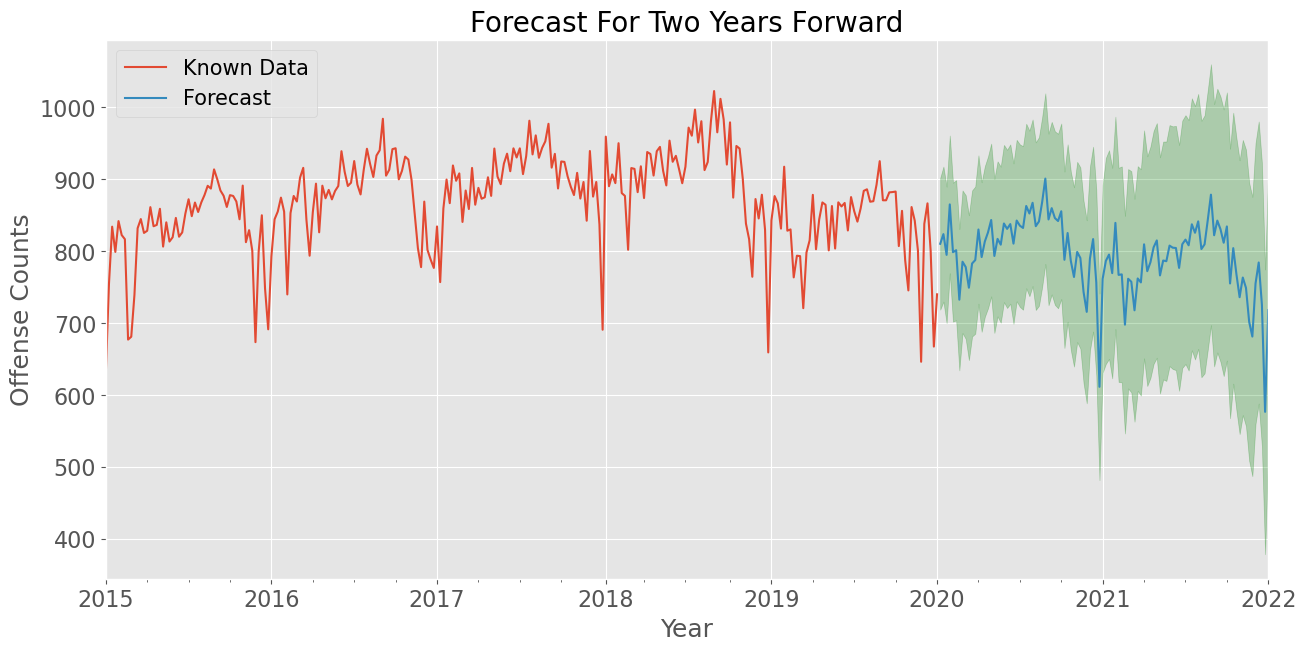

In [73]:
fig=plot_predictions(ts_weekly, model_auto_for, 'Forecast For Two Years Forward', steps=104, xmin='2015')

In [74]:
with open('images/pickled_figs/auto_arima_forecast.pickle', 'wb') as f:
    pickle.dump(fig,f)

In [75]:
plot_predictions_px(ts_weekly, model_auto_for, 'Crime Data and Forecast for Two Years', xmin='2015')

<br><br><span style="font-size:1.2em;">**It takes ~3 minutes to run this notebook**</span>

<br><br><span style="font-size:1.2em;">All Crime rate modeling for various crime categories are located in [part IV notebook.](capstone_project_categorical_crime_modeling.ipynb)</span><br><br>